# Load data

In [1]:
from numpy import loadtxt

features = loadtxt("London_data_2x1000Center_bin100.dat")
position = loadtxt("London_data_2x1000Center_bin100_pos.dat") / 3.5

print features.shape, position.shape

(5400, 344) (5400, 2)



# Split into training and test set

Currently using first 80% as training and last 20% as test set.

In [2]:
nr_samples = features.shape[0]
nr_train = 4000
nr_test = nr_samples - nr_train

train_X = features[:nr_train]
train_Y = position[:nr_train]
test_X = features[nr_train:]
test_Y = position[nr_train:]

print train_X.shape, train_Y.shape, test_X.shape, test_Y.shape

(4000, 344) (4000, 2) (1400, 344) (1400, 2)


## Helper function to calculate mean distance

In [3]:
import numpy as np

def mean_distance(estimator, X, y):
    pred_y = estimator.predict(X)
    return np.mean(np.sqrt(np.sum((pred_y - y) ** 2, axis=1)))

def mean_distance_scoring(estimator, X, y):
    return -mean_distance(estimator, X, y)

# Random forest

## First take with default parameters

The result is better than with linear model. Overfitting is a problem.

In [4]:
from sklearn.ensemble.forest import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(train_X, train_Y)

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(rf, train_X, train_Y), mean_distance(rf, test_X, test_Y), rf.score(test_X, test_Y))

Train mean distance 3.298146, test mean distance: 17.439380, test R^2 score 0.650173


## Grid search

In [5]:
from sklearn.grid_search import GridSearchCV

tuned_parameters = [{'n_estimators': [10, 100, 1000], 
                     'max_features': ['auto', 'sqrt', 0.5],
                     'max_depth': [None, 10, 20],
                     'min_samples_leaf': [1, 10, 100]}]

cv = GridSearchCV(RandomForestRegressor(n_jobs=2), tuned_parameters, scoring=mean_distance_scoring, cv=5, verbose=2)
cv.fit(train_X, train_Y)

print cv.best_params_, cv.best_score_

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(cv, train_X, train_Y), mean_distance(cv, test_X, test_Y), cv.score(test_X, test_Y))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 
[CV]  max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 -   1.0s
[CV] max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 
[CV]  max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 -   0.9s
[CV] max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 
[CV]  max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 -   1.0s
[CV] max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 
[CV]  max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 -   0.9s
[CV] max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 
[CV]  max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 -   1.4s
[CV] max_features=auto, n_estimators=100, max_depth=None, min_samples_leaf=1 
[CV]  max_features=auto, n_estimators=100, ma

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed: 16.3min
[Parallel(n_jobs=1)]: Done 161 tasks       | elapsed: 41.2min



[CV] max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 
[CV]  max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 -  56.3s
[CV] max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 
[CV]  max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 -  53.9s
[CV] max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 
[CV]  max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 -  55.1s
[CV] max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 
[CV]  max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 -  57.4s
[CV] max_features=auto, n_estimators=10, max_depth=10, min_samples_leaf=100 
[CV]  max_features=auto, n_estimators=10, max_depth=10, min_samples_leaf=100 -   0.6s
[CV] max_features=auto, n_estimators=10, max_depth=10, min_samples_leaf=100 
[CV]  max_features=auto, n_estimators=10, max_depth=10, min_samples_leaf=100 -   0.5s
[CV] max_feat

[Parallel(n_jobs=1)]: Done 364 tasks       | elapsed: 79.7min
[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed: 89.8min finished



{'max_features': 0.5, 'n_estimators': 1000, 'max_depth': None, 'min_samples_leaf': 1} -15.5167879519
Train mean distance 2.470214, test mean distance: 16.016856, test R^2 score -16.016856


/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:418: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


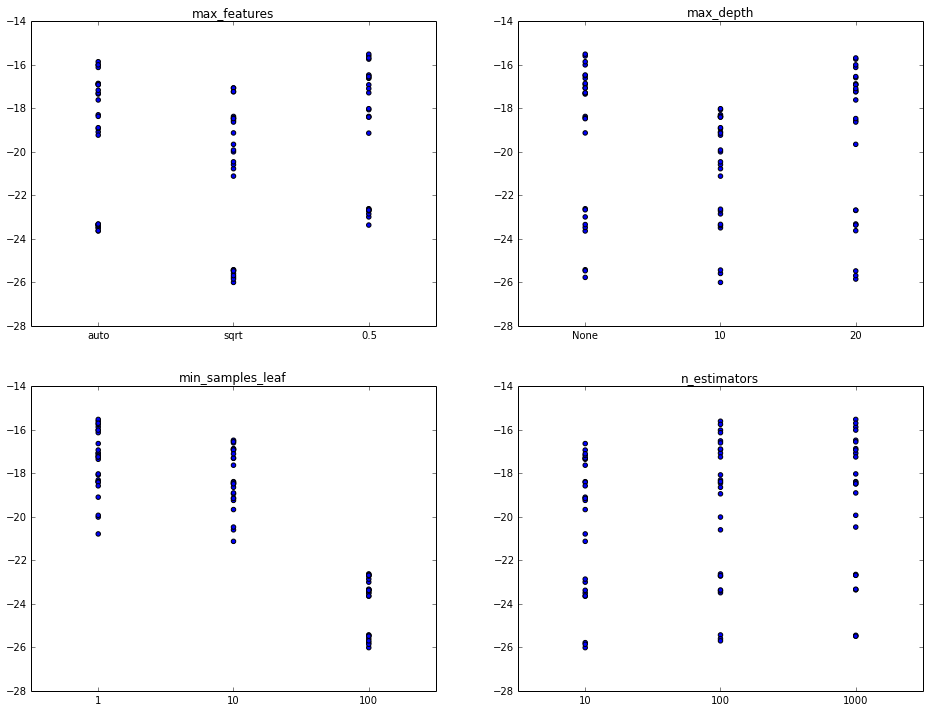

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

for params in tuned_parameters:
    plt.figure(figsize=(16,12))
    ncols = int(math.ceil(math.sqrt(len(params))))
    nrows = int(math.ceil(len(params) / ncols))
    for i, (param, values) in enumerate(params.iteritems()):
        #print i, param, values
        value_to_index = {v:i for i,v in enumerate(values)}
        scores = []
        indexes = []
        for cv_tuple in cv.grid_scores_:
            scores.append(cv_tuple.mean_validation_score)
            value = cv_tuple.parameters[param]
            indexes.append(value_to_index[value])
        plt.subplot(nrows,ncols,i)
        plt.scatter(indexes, scores)
        plt.xticks(range(len(values)), values)
        plt.title(param)
    plt.show()

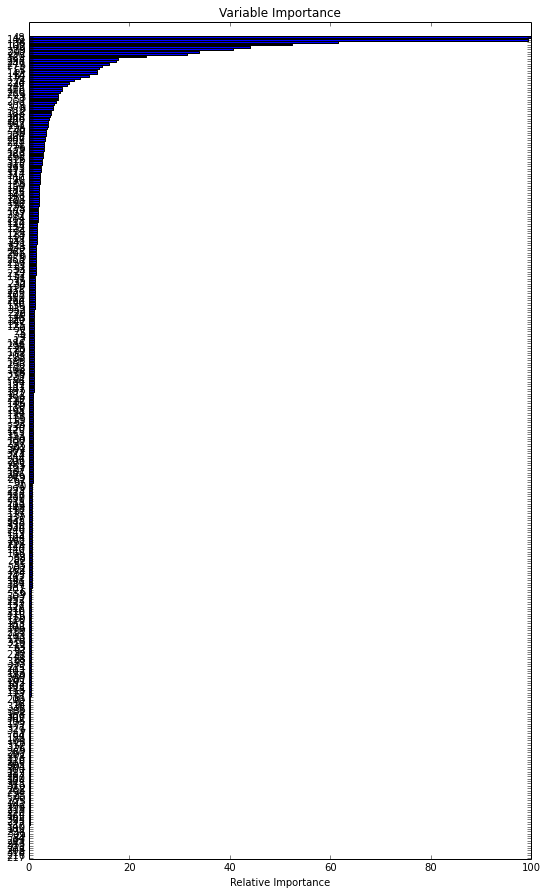

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot feature importance
feature_importance = cv.best_estimator_.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(9,15))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, sorted_idx)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

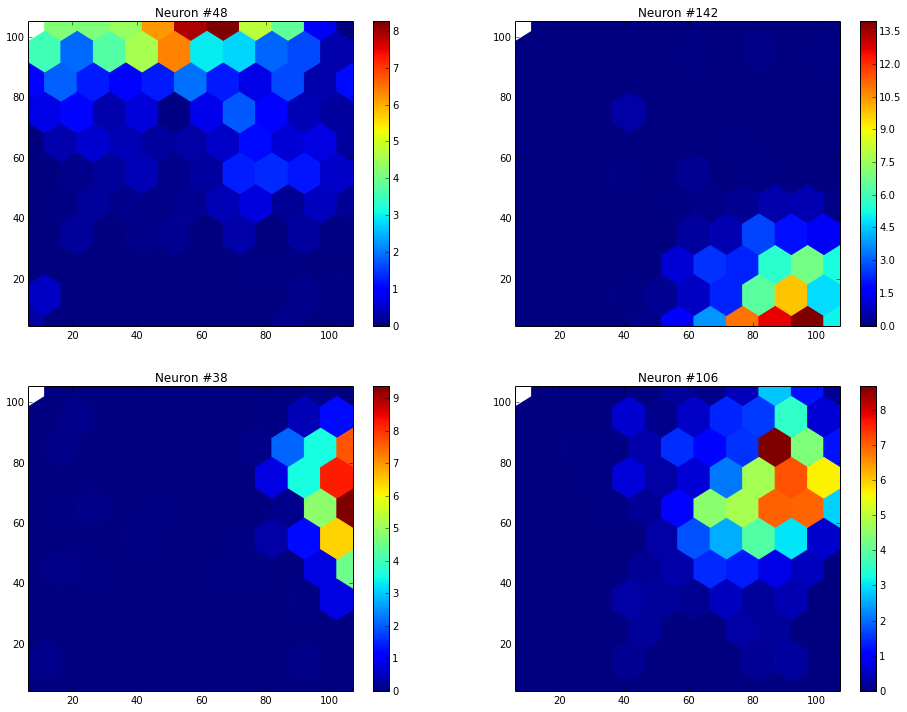

In [8]:
plt.figure(figsize=(16,12))
for i in xrange(1,5):
    plt.subplot(2,2,i)
    plt.hexbin(position[...,0], position[...,1], features[...,sorted_idx[-i]], gridsize = 10)
    plt.colorbar()
    plt.title("Neuron #%d" % sorted_idx[-i])

# Extremely randomized trees

Worked slightly better with default parameters, but no major leap.

In [9]:
from sklearn.ensemble import ExtraTreesRegressor

et = ExtraTreesRegressor()
et.fit(train_X, train_Y)

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(et, train_X, train_Y), mean_distance(et, test_X, test_Y), et.score(test_X, test_Y))

Train mean distance 0.000000, test mean distance: 16.547077, test R^2 score 0.701151


In [10]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.grid_search import GridSearchCV

tuned_parameters = [{'n_estimators': [10, 100, 1000], 
                     'max_features': ['auto', 'sqrt', 0.5],
                     'max_depth': [None, 10, 20],
                     'min_samples_leaf': [1, 10, 100]}]

cv = GridSearchCV(ExtraTreesRegressor(n_jobs=2), tuned_parameters, scoring=mean_distance_scoring, cv=5, verbose=2)
cv.fit(train_X, train_Y)

print cv.best_params_, cv.best_score_

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(cv, train_X, train_Y), mean_distance(cv, test_X, test_Y), cv.score(test_X, test_Y))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 
[CV]  max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 -   1.4s
[CV] max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 
[CV]  max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 -   1.3s
[CV] max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 
[CV]  max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 -   1.3s
[CV] max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 
[CV]  max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 -   1.2s
[CV] max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 
[CV]  max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 -   1.4s
[CV] max_features=auto, n_estimators=100, max_depth=None, min_samples_leaf=1 
[CV]  max_features=auto, n_estimators=100, ma

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed: 13.0min
[Parallel(n_jobs=1)]: Done 161 tasks       | elapsed: 31.7min



[CV] max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 
[CV]  max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 -  35.4s
[CV] max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 
[CV]  max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 -  31.6s
[CV] max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 
[CV]  max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 -  32.0s
[CV] max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 
[CV]  max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 -  33.9s
[CV] max_features=auto, n_estimators=10, max_depth=10, min_samples_leaf=100 
[CV]  max_features=auto, n_estimators=10, max_depth=10, min_samples_leaf=100 -   0.6s
[CV] max_features=auto, n_estimators=10, max_depth=10, min_samples_leaf=100 
[CV]  max_features=auto, n_estimators=10, max_depth=10, min_samples_leaf=100 -   0.6s
[CV] max_feat

[Parallel(n_jobs=1)]: Done 364 tasks       | elapsed: 59.8min
[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed: 68.6min finished



{'max_features': 'auto', 'n_estimators': 100, 'max_depth': None, 'min_samples_leaf': 1} -14.765886507
Train mean distance 0.000000, test mean distance: 15.316130, test R^2 score -15.316130


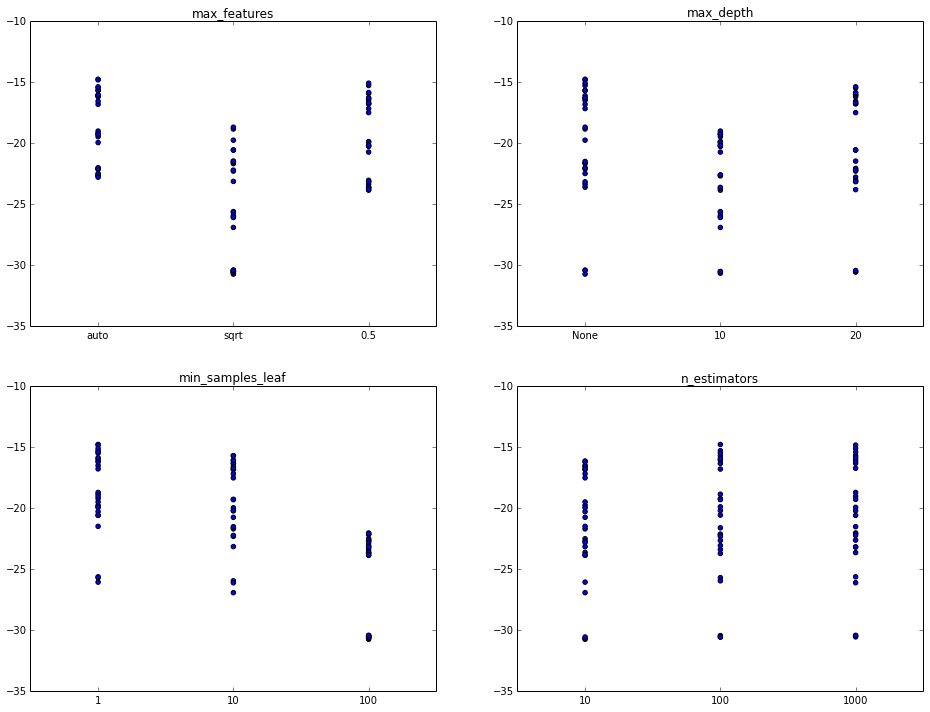

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

for params in tuned_parameters:
    plt.figure(figsize=(16,12))
    ncols = int(math.ceil(math.sqrt(len(params))))
    nrows = int(math.ceil(len(params) / ncols))
    for i, (param, values) in enumerate(params.iteritems()):
        #print i, param, values
        value_to_index = {v:i for i,v in enumerate(values)}
        scores = []
        indexes = []
        for cv_tuple in cv.grid_scores_:
            scores.append(cv_tuple.mean_validation_score)
            value = cv_tuple.parameters[param]
            indexes.append(value_to_index[value])
        plt.subplot(nrows,ncols,i)
        plt.scatter(indexes, scores)
        plt.xticks(range(len(values)), values)
        plt.title(param)
    plt.show()

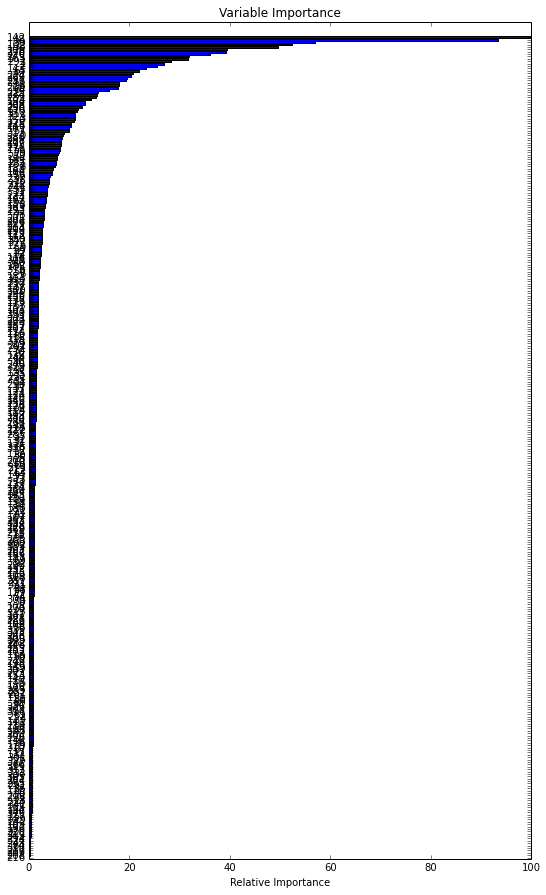

In [12]:
# Plot feature importance
feature_importance = cv.best_estimator_.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(9,15))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, sorted_idx)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Gradient Boosted Regression Trees

## Helper class for multiple output regression

In [13]:
import sklearn

class VectorRegression(sklearn.base.BaseEstimator, sklearn.base.RegressorMixin):
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y):
        n, m = y.shape
        # Fit a separate regressor for each column of y
        self.estimators_ = [sklearn.base.clone(self.estimator).fit(X, y[:, i])
                               for i in range(m)]
        return self

    def predict(self, X):
        # Join regressors' predictions
        res = [est.predict(X)[:, np.newaxis] for est in self.estimators_]
        return np.hstack(res)

    def set_params(self, **params):
        self.estimator.set_params(**params)
        return self

## First try defaults

Clearly underfits.

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
gb = VectorRegression(GradientBoostingRegressor())
gb.fit(train_X, train_Y)

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(gb, train_X, train_Y), mean_distance(gb, test_X, test_Y), gb.score(test_X,  test_Y))

Train mean distance 10.746564, test mean distance: 16.644751, test R^2 score 0.701145


## Grid search

In [15]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV

tuned_parameters = [{'learning_rate': [1, 0.5, 0.1], 
                     'n_estimators': [10, 100, 1000],
                     'max_depth': [3, 5, 10],
                     'subsample': [1.0, 0.5, 0.1]}]

gb = VectorRegression(GradientBoostingRegressor())
cv = GridSearchCV(gb, tuned_parameters, scoring=mean_distance_scoring, cv=5, n_jobs=2, verbose=2)
cv.fit(train_X, train_Y)

print cv.best_params_, cv.best_score_

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(cv, train_X, train_Y), mean_distance(cv, test_X, test_Y), cv.score(test_X, test_Y))

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 12.7min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed: 76.8min
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed: 205.1min
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed: 268.5min finished


{'n_estimators': 100, 'subsample': 0.5, 'learning_rate': 0.1, 'max_depth': 10} -14.90726184
Train mean distance 1.453218, test mean distance: 15.302382, test R^2 score -15.302382[CV] n_estimators=10, subsample=1.0, learning_rate=1, max_depth=3 ....
[CV] n_estimators=10, subsample=1.0, learning_rate=1, max_depth=3 ....
[CV]  n_estimators=10, subsample=1.0, learning_rate=1, max_depth=3 -   1.8s[CV]  n_estimators=10, subsample=1.0, learning_rate=1, max_depth=3 -   2.3s

[CV] n_estimators=10, subsample=1.0, learning_rate=1, max_depth=3 ....
[CV] n_estimators=10, subsample=1.0, learning_rate=1, max_depth=3 ....
[CV]  n_estimators=10, subsample=1.0, learning_rate=1, max_depth=3 -   1.8s[CV]  n_estimators=10, subsample=1.0, learning_rate=1, max_depth=3 -   2.4s

[CV] n_estimators=10, subsample=1.0, learning_rate=1, max_depth=3 ....
[CV] n_estimators=10, subsample=0.5, learning_rate=1, max_depth=3 ....
[CV]  n_estimators=10, subsample=1.0, learning_rate=1, max_depth=3 -   1.7s[CV]  n_estimator

In [ ]:
feature_importance